In [1]:
import json
import os
from pathlib import Path
from itertools import permutations

import joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, welch
from scipy.stats import skew, kurtosis, pearsonr

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import (
    GroupShuffleSplit,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier



In [2]:
## Mauvaise prediction de la classe 1 pour l'instant
## Regarder pour scaler les trucs pour chaque signal et pas accros tout les samples 
## Cyp affirme que le choix du model et des parametre ne devrait pas faire autant de diff avec le top du leaderbord, c'est qu il nous faut des meilleur feature
## Donne code + papier d'edunao a claude et ameliorer les features
## Utilisation quand on cree les features, je sais pas si y a pas possiblement du dataleakage (mais cela ne devrait pas impacter quand on entraine sur tout le dataset pour la submission)
## Une piste pourrait etre d'utiliser un des 7 signaux (individu) comme test set, parce je crois que la on overfit peut etre trop aux individus que nous on a (et qui ne sont pas dans le test set )

In [3]:
# Set up global variables

# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025") 
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025


## Load Data and Create Features

In [4]:
# Load data and store it in simple dataframe

def load_data(path):
    signals = {}
    for root, _, files in os.walk(path):
        for file in sorted(files):  # Sort for consistency
            file_path = os.path.join(root, file)
            # Extract the actual signal number from filename (e.g., "signal_8.npy" -> 8)
            signal_num = int(file.split('_')[-1].split('.')[0])
            signals[signal_num] = np.load(file_path)
    return signals

def format_data(train):
    # Define base columns
    base_columns = ['captor_0', 'captor_1', 'captor_2', 'captor_3', 'captor_4', 'num_epoch', 'num_signal']
    
    # Add target column only for training data
    if train:
        columns = base_columns.copy()
        columns.insert(5, 'target')  # Insert target at position 5 (after captors, before num_epoch)
        signals = load_data('signals_train')
        targets = load_data('targets_train')
    else:
        columns = base_columns
        signals = load_data('signals_test')
    
    main_df = pd.DataFrame(columns=columns)

    for signal_idx in signals.keys():
        signal = signals[signal_idx]

        ########### Scale the signal
        signal = (signal - signal.mean(axis=1, keepdims=True)) / (signal.std(axis=1, keepdims=True) + 1e-8)
        
        ###########
        if train:
            target = targets[signal_idx]
        
        # Split signal into chunks of 3000
        splited_signal = np.array_split(signal, np.arange(3000, signal.shape[1], 3000), axis=1)
        
        # Create DataFrame for this signal
        df = pd.DataFrame(
            index=range(len(splited_signal)),
            columns=[f"captor_{i}" for i in range(5)]
        )
        
        # Fill captor data
        for idx, signal_matrix in enumerate(splited_signal):
            for captor in range(signal_matrix.shape[0]):
                df.loc[idx, f"captor_{captor}"] = signal_matrix[captor, :].squeeze()
        
        # Add metadata columns
        df['num_epoch'] = df.index
        df['num_signal'] = signal_idx
        
        # Add target only for training data
        if train:
            df['target'] = target
        
        # Reorder columns to match main_df structure
        df = df[columns]
        
        # Concatenate with main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)
        main_df = main_df.sort_values(['num_signal', 'num_epoch'])

    return main_df


In [5]:
# Feature extraction of previous dataframe          


def extract_time_features(signal):
    """Extract time domain features from a signal."""
    features = {
        'std': float(np.std(signal)),
        'mean': float(np.mean(signal)),
        'min': float(np.min(signal)),
        'max': float(np.max(signal)),
        'ptp': float(np.ptp(signal)),
        'skew': float(skew(signal)),
        'kurtosis': float(kurtosis(signal)),
        'rms': float(np.sqrt(np.mean(signal**2))),
        'median': float(np.median(signal))
    }
    return features


def spectral_entropy(psd):
    """Spectral entropy from a PSD array."""
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    return -np.sum(psd_norm * np.log(psd_norm + 1e-12))


def permutation_entropy(signal, order=3, delay=1):
    """Permutation entropy of a 1D signal."""
    n = len(signal)
    perms = list(permutations(range(order)))
    c = np.zeros(len(perms))

    for i in range(n - delay * (order - 1)):
        pattern = signal[i:i + delay * order:delay]
        rank = tuple(np.argsort(pattern))
        c[perms.index(rank)] += 1

    p = c / np.sum(c) if np.sum(c) > 0 else c
    p = p[p > 0]

    return -np.sum(p * np.log(p))



def extract_frequency_features(signal):
    """Extract frequency domain + entropy features from a signal."""
    features = {}
    
    # PSD using Welch (already correct)
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)

    # ---------- GLOBAL SPECTRAL ENTROPY ----------
    features['spectral_entropy'] = float(spectral_entropy(psd))

    # Define sleep frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'sigma': (12, 15),
        'beta': (13, 30)
    }

    # ---------- BAND FEATURES + BAND ENTROPY ----------
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)

        if np.any(band_mask):
            band_psd = psd[band_mask]
            band_power = np.sum(band_psd)

            features[f'{band_name}_power'] = float(band_power)
            features[f'{band_name}_rel_power'] = float(
                band_power / total_power if total_power > 0 else 0
            )

            # Band spectral entropy
            features[f'{band_name}_entropy'] = float(
                spectral_entropy(band_psd)
            )
        else:
            features[f'{band_name}_power'] = 0.0
            features[f'{band_name}_rel_power'] = 0.0
            features[f'{band_name}_entropy'] = 0.0

    # Spectral edge frequency (95%)
    cumsum_psd = np.cumsum(psd)
    if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
        sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
        features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)

    features['total_power'] = float(total_power)

    return features


def extract_channel_features(channel_signal):
    """Extract all features for a single channel."""
    time_features = extract_time_features(channel_signal)
    freq_features = extract_frequency_features(channel_signal)

    # ---------- PERMUTATION ENTROPY ----------
    time_features['permutation_entropy'] = float(
        permutation_entropy(channel_signal, order=3, delay=1)
    )

    return {**time_features, **freq_features}


def extract_cross_channel_features(channel_signals):
    """Extract features that involve multiple channels."""
    features = {}
    
    # Correlations between channel pairs
    for i in range(NUM_CHANNELS):
        for j in range(i+1, NUM_CHANNELS):
            corr, _ = pearsonr(channel_signals[i], channel_signals[j])
            features[f'corr_ch{i}_ch{j}'] = float(corr)
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    features['spatial_std'] = float(np.std(channel_stds))
    features['spatial_mean_std'] = float(np.mean(channel_stds))
    
    return features

def add_temporal_context(features_df, window=3):
    """Add rolling statistics to capture temporal patterns."""
    # Add rolling statistics for key features
    key_features = ['ch0_delta_power', 'ch0_alpha_power', 'ch0_sigma_power']
    
    for col in key_features:
        if col in features_df.columns:
            # Rolling statistics within each signal
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                # Rolling mean
                rolling_mean = features_df.loc[mask, col].rolling(window, center=True).mean()
                features_df.loc[mask, f'{col}_roll_mean_{window}'] = rolling_mean
                
                # Rolling std
                rolling_std = features_df.loc[mask, col].rolling(window, center=True).std()
                features_df.loc[mask, f'{col}_roll_std_{window}'] = rolling_std
                
                # Difference from previous epoch
                features_df.loc[mask, f'{col}_diff_{window}'] = features_df.loc[mask, col].diff()
    
    # Fill NaN values
    features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return features_df

def process_single_epoch(row):
    """Process a single epoch (row) to extract all features."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        # Get signal for this channel
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract channel features
        ch_features = extract_channel_features(signal)
        
        # Add channel prefix to feature names
        for key, value in ch_features.items():
            features[f'ch{ch}_{key}'] = value
        
        channel_signals.append(signal)
    
    # Extract cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    return features


def add_lagged_features(df_features):
    # top 20 features from previously trained XGboost, used to create lagged features
    top_20_features = ['ch2_permutation_entropy',
    'ch1_beta_entropy',
    'ch3_alpha_rel_power',
    'ch4_sef95',
    'ch3_beta_entropy',
    'ch3_permutation_entropy',
    'ch2_sigma_power',
    'ch3_delta_power',
    'ch0_delta_rel_power',
    'ch0_sigma_power_roll_mean_3',
    'ch4_alpha_power',
    'ch0_delta_power_roll_mean_3',
    'ch2_sef95',
    'ch3_beta_rel_power',
    'ch2_delta_rel_power',
    'ch1_permutation_entropy',
    'ch4_spectral_entropy',
    'ch2_delta_power',
    'ch0_delta_power_roll_mean_50',
    'ch0_beta_entropy']    
    

    lags = [-3, -2, -1, 1] 

    # 4. Vectorized implementation (No loops over rows!)
    for lag in lags:
        shifted_data = df_features.groupby('num_signal')[top_20_features].shift(lag)
        shifted_data.columns = [f"lagged_feature_{col}_{lag}" for col in top_20_features]
        df_features = pd.concat([df_features, shifted_data], axis=1)

    df_features = df_features.fillna(0)
    return df_features


def create_features_parallel(df):
    print(f"Processing {len(df)} epochs in parallel...")
    
    # Run process_single_epoch across all available CPU cores
    results = Parallel(n_jobs=-1)(
        delayed(process_single_epoch)(row) for _, row in df.iterrows()
    )
    
    features_df = pd.DataFrame(results)
    
    # Temporal context remains sequential as it depends on ordering
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df, 3)
    features_df = add_temporal_context(features_df, 50)
    features_df = add_temporal_context(features_df, 500)

    features_df = add_lagged_features(features_df)
    return features_df


In [6]:
# # Test new feature extraction Gemini

# import numpy as np
# from scipy.signal import welch
# from scipy.stats import skew, kurtosis

# # ==========================================
# # 1. Ajout de la bande Gamma et des Ratios
# # ==========================================
# def extract_frequency_features(signal, fs=100):
#     """
#     Extrait les features fréquentielles incluant la bande Gamma 
#     et des ratios spectraux pertinents.
#     """
#     features = {}
    
#     # Calcul du PSD avec Welch
#     freqs, psd = welch(signal, fs=fs, nperseg=min(256, len(signal)))
#     total_power = np.sum(psd)

#     # ---------- GLOBAL SPECTRAL ENTROPY ----------
#     # (Votre fonction spectral_entropy existante)
#     features['spectral_entropy'] = float(spectral_entropy(psd))

#     # Définition des bandes (Ajout de GAMMA) [cite: 1, 2]
#     bands = {
#         'delta': (0.5, 4),
#         'theta': (4, 8),
#         'alpha': (8, 13),
#         'sigma': (12, 15),
#         'beta': (13, 30),
#         'gamma': (30, 49) # La fréquence d'échantillonnage est 100Hz, Nyquist est 50Hz
#     }

#     band_powers = {}

#     # ---------- BAND FEATURES ----------
#     for band_name, (low, high) in bands.items():
#         band_mask = (freqs >= low) & (freqs <= high)
#         if np.any(band_mask):
#             val = np.sum(psd[band_mask])
#         else:
#             val = 0.0
        
#         band_powers[band_name] = val
#         features[f'{band_name}_power'] = float(val)
#         features[f'{band_name}_rel_power'] = float(val / total_power if total_power > 0 else 0)

#     # ---------- SPECTRAL RATIOS ----------
#     # Ces ratios aident souvent à distinguer le sommeil profond (Delta dominant) de l'éveil/REM
#     epsilon = 1e-8
#     features['ratio_delta_theta'] = band_powers['delta'] / (band_powers['theta'] + epsilon)
#     features['ratio_delta_alpha'] = band_powers['delta'] / (band_powers['alpha'] + epsilon)
#     features['ratio_delta_beta']  = band_powers['delta'] / (band_powers['beta'] + epsilon)
#     features['ratio_theta_alpha'] = band_powers['theta'] / (band_powers['alpha'] + epsilon)
    
#     # Spectral Edge Frequency 95%
#     cumsum_psd = np.cumsum(psd)
#     if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
#         sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
#         features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)
#     else:
#         features['sef95'] = 0.0

#     features['total_power'] = float(total_power)
#     return features

# # ==========================================
# # 2. Nouvelles Features Non-Linéaires & Temporelles
# # ==========================================
# def higuchi_fd(signal, kmax=10):
#     """Calcule la dimension fractale de Higuchi (complexité)."""
#     L = []
#     x = []
#     N = len(signal)
#     for k in range(1, kmax):
#         Lk = []
#         for m in range(0, k):
#             Lmk = 0
#             for i in range(1, int(np.floor((N - m) / k))):
#                 Lmk += abs(signal[m + i * k] - signal[m + (i - 1) * k])
#             Lmk = Lmk * (N - 1) / np.floor((N - m) / float(k)) / k
#             Lk.append(Lmk)
#         L.append(np.log(np.mean(Lk)))
#         x.append([np.log(1.0/ k), 1])
    
#     # Fit linéaire pour trouver la pente
#     (p, _) = np.linalg.lstsq(x, L, rcond=None)[0]
#     return p

# def hjorth_params(signal):
#     """Calcule les paramètres de Hjorth: Activity, Mobility, Complexity."""
#     first_deriv = np.diff(signal)
#     second_deriv = np.diff(signal, 2)

#     var_zero = np.var(signal)
#     var_d1 = np.var(first_deriv)
#     var_d2 = np.var(second_deriv)

#     activity = var_zero
#     mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
#     complexity = (np.sqrt(var_d2 / var_d1) / mobility) if var_d1 > 0 and mobility > 0 else 0

#     return activity, mobility, complexity

# def extract_advanced_time_features(signal):
#     """
#     Ajoute les features avancées recommandées par la littérature (Entropy 2016).
#     """
#     features = {}
    
#     # --- Hjorth Parameters  ---
#     act, mob, comp = hjorth_params(signal)
#     features['hjorth_activity'] = float(act)
#     features['hjorth_mobility'] = float(mob)
#     features['hjorth_complexity'] = float(comp)
    
#     # --- Zero Crossing Rate  ---
#     # Centrer le signal avant de compter les passages par zéro
#     signal_centered = signal - np.mean(signal)
#     zcr = ((signal_centered[:-1] * signal_centered[1:]) < 0).sum()
#     features['zero_crossing_rate'] = float(zcr) / len(signal)
    
#     # --- Higuchi Fractal Dimension  ---
#     # Note: kmax=10 est une valeur standard pour l'EEG
#     try:
#         features['higuchi_fd'] = float(higuchi_fd(signal, kmax=10))
#     except:
#         features['higuchi_fd'] = 0.0

#     return features

# # ==========================================
# # 3. Mise à jour de la fonction extract_channel_features
# # ==========================================
# def extract_channel_features(channel_signal):
#     """Combine toutes les extractions pour un canal."""
#     # Features temporelles de base (votre fonction existante)
#     time_features = extract_time_features(channel_signal)
    
#     # Features fréquentielles (Mise à jour avec Gamma + Ratios)
#     freq_features = extract_frequency_features(channel_signal, fs=SAMPLING_RATE)
    
#     # Features avancées (Hjorth, ZCR, FD)
#     adv_features = extract_advanced_time_features(channel_signal)

#     # Permutation entropy (votre fonction existante)
#     # Le papier cite aussi "Permutation entropy" comme feature non-linéaire utile 
#     pe = float(permutation_entropy(channel_signal, order=3, delay=1))
    
#     # Fusionner tout
#     all_features = {**time_features, **freq_features, **adv_features}
#     all_features['permutation_entropy'] = pe
    
#     return all_features


# from scipy.signal import hilbert, butter, filtfilt
# from scipy.linalg import svd

# # ==========================================
# # 4. Features de Morphologie et Complexité Avancée
# # ==========================================

# def petrosian_fd(signal):
#     """
#     Dimension Fractale de Petrosian.
#     Plus rapide que Higuchi, elle mesure la 'rugosité' du signal via les changements de signe de la dérivée.
#     Pertinent pour : Éveil vs NREM.
#     """
#     diff = np.diff(signal)
#     # Nombre de changements de signe dans la dérivée
#     n_delta = (diff[:-1] * diff[1:] < 0).sum()
#     n = len(signal)
#     if n_delta == 0:
#         return 1.0
#     return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * n_delta)))

# def svd_entropy(signal, delay=1, embed_dim=3):
#     """
#     Entropie SVD (Singular Value Decomposition).
#     Mesure la complexité du signal en reconstruisant un espace de phase.
#     Pertinent pour : REM vs N1/Éveil.
#     """
#     # Création de la matrice de trajectoire (Embedding)
#     n = len(signal)
#     if n < delay * (embed_dim - 1):
#         return 0
    
#     # Matrice retardée
#     mat = np.array([signal[i : n - (embed_dim - 1 - i) * delay] 
#                     for i in range(embed_dim)])
    
#     # Valeurs singulières
#     try:
#         W = svd(mat, compute_uv=False)
#         W /= np.sum(W)  # Normalisation
#         return -np.sum(W * np.log(W + 1e-12))
#     except:
#         return 0

# def spectral_moments(freqs, psd):
#     """
#     Calcule le centre de masse (Mean Freq) et la dispersion (Bandwidth) du spectre.
#     Pertinent pour : Changements globaux du spectre (ex: ralentissement en sommeil profond).
#     """
#     psd_sum = np.sum(psd)
#     if psd_sum == 0:
#         return 0, 0
    
#     # Moyenne pondérée (Spectral Centroid)
#     mean_freq = np.sum(freqs * psd) / psd_sum
    
#     # Écart-type spectral (Spectral Bandwidth)
#     bandwidth = np.sqrt(np.sum(((freqs - mean_freq) ** 2) * psd) / psd_sum)
    
#     return mean_freq, bandwidth

# def sigma_spindle_feature(signal, fs=100):
#     """
#     Mesure la variabilité de l'enveloppe dans la bande Sigma (12-15 Hz).
#     Une variance élevée indique la présence de 'bursts' (fuseaux), typiques du stade N2.
#     """
#     # Filtre passe-bande Sigma (12-15 Hz)
#     nyq = 0.5 * fs
#     low = 12 / nyq
#     high = 15 / nyq
#     b, a = butter(4, [low, high], btype='band')
    
#     try:
#         filtered = filtfilt(b, a, signal)
#         # Transformée de Hilbert pour obtenir l'enveloppe
#         envelope = np.abs(hilbert(filtered))
        
#         # Features de l'enveloppe
#         return {
#             'sigma_env_mean': float(np.mean(envelope)),
#             'sigma_env_std': float(np.std(envelope)),  # Indicateur clé de présence de fuseaux
#             'sigma_env_max': float(np.max(envelope))
#         }
#     except:
#         return {'sigma_env_mean': 0, 'sigma_env_std': 0, 'sigma_env_max': 0}
    



# def extract_channel_features(channel_signal):
#     """Combine TOUTES les extractions pour un canal."""
    
#     # 1. Temporelles de base
#     time_features = extract_time_features(channel_signal)
    
#     # 2. Fréquentielles (avec les bandes mises à jour précédemment)
#     freq_features = extract_frequency_features(channel_signal, fs=SAMPLING_RATE)
    
#     # 3. Avancées (Hjorth, ZCR, Higuchi - du message précédent)
#     adv_features = extract_advanced_time_features(channel_signal)
    
#     # --- NOUVEAUX AJOUTS ---
    
#     # 4. Dimension Fractale Petrosian (Rapide)
#     pfd = petrosian_fd(channel_signal)
    
#     # 5. SVD Entropy
#     svd_en = svd_entropy(channel_signal)
    
#     # 6. Moments Spectraux (Besoin de re-calculer PSD ou récupérer de freq_features si adapté)
#     # Pour faire simple, on recalcule rapidement ici ou on modifie extract_frequency_features
#     # Utilisons welch localement pour être indépendant
#     f_ax, psd_val = welch(channel_signal, fs=SAMPLING_RATE, nperseg=min(256, len(channel_signal)))
#     spec_mean, spec_bw = spectral_moments(f_ax, psd_val)
    
#     # 7. Détection Spindle (Sigma Envelope)
#     spindle_feats = sigma_spindle_feature(channel_signal, fs=SAMPLING_RATE)

#     # Fusion
#     extra_features = {
#         'petrosian_fd': float(pfd),
#         'svd_entropy': float(svd_en),
#         'spectral_mean': float(spec_mean),
#         'spectral_bandwidth': float(spec_bw),
#         **spindle_feats
#     }
    
#     # Permutation entropy existante
#     pe = float(permutation_entropy(channel_signal, order=3, delay=1))
    
#     # Tout combiner
#     all_features = {
#         **time_features, 
#         **freq_features, 
#         **adv_features, 
#         **extra_features,
#         'permutation_entropy': pe
#     }
    
#     return all_features





In [7]:
# Create the submission file

def create_submission(df_test, predictions, file_name = ''):
    # num_signal already contains the correct signal numbers
    identifiers = df_test['num_signal'] * 10000 + df_test['num_epoch']
    
    submission = pd.DataFrame({
        'identifier': identifiers.astype(int),
        'target': predictions.astype(int)
    })
    
    submission = submission.sort_values('identifier').reset_index(drop=True)
    submission.to_csv(file_name + 'submission.csv', index=False)

    # Check wether everything wnt well while creating the submission file
    df_ok = pd.read_csv('sample.csv')
    set1 = set(submission.identifier)
    set2 = set(df_ok.identifier)
    difference = set1.symmetric_difference(set2)
    print('labels that are not in boths sets : ', difference)
    
    return submission

## Data exploration

In [8]:
df = format_data(True)
df_features = create_features_parallel(df)

Processing 7433 epochs in parallel...
Adding temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


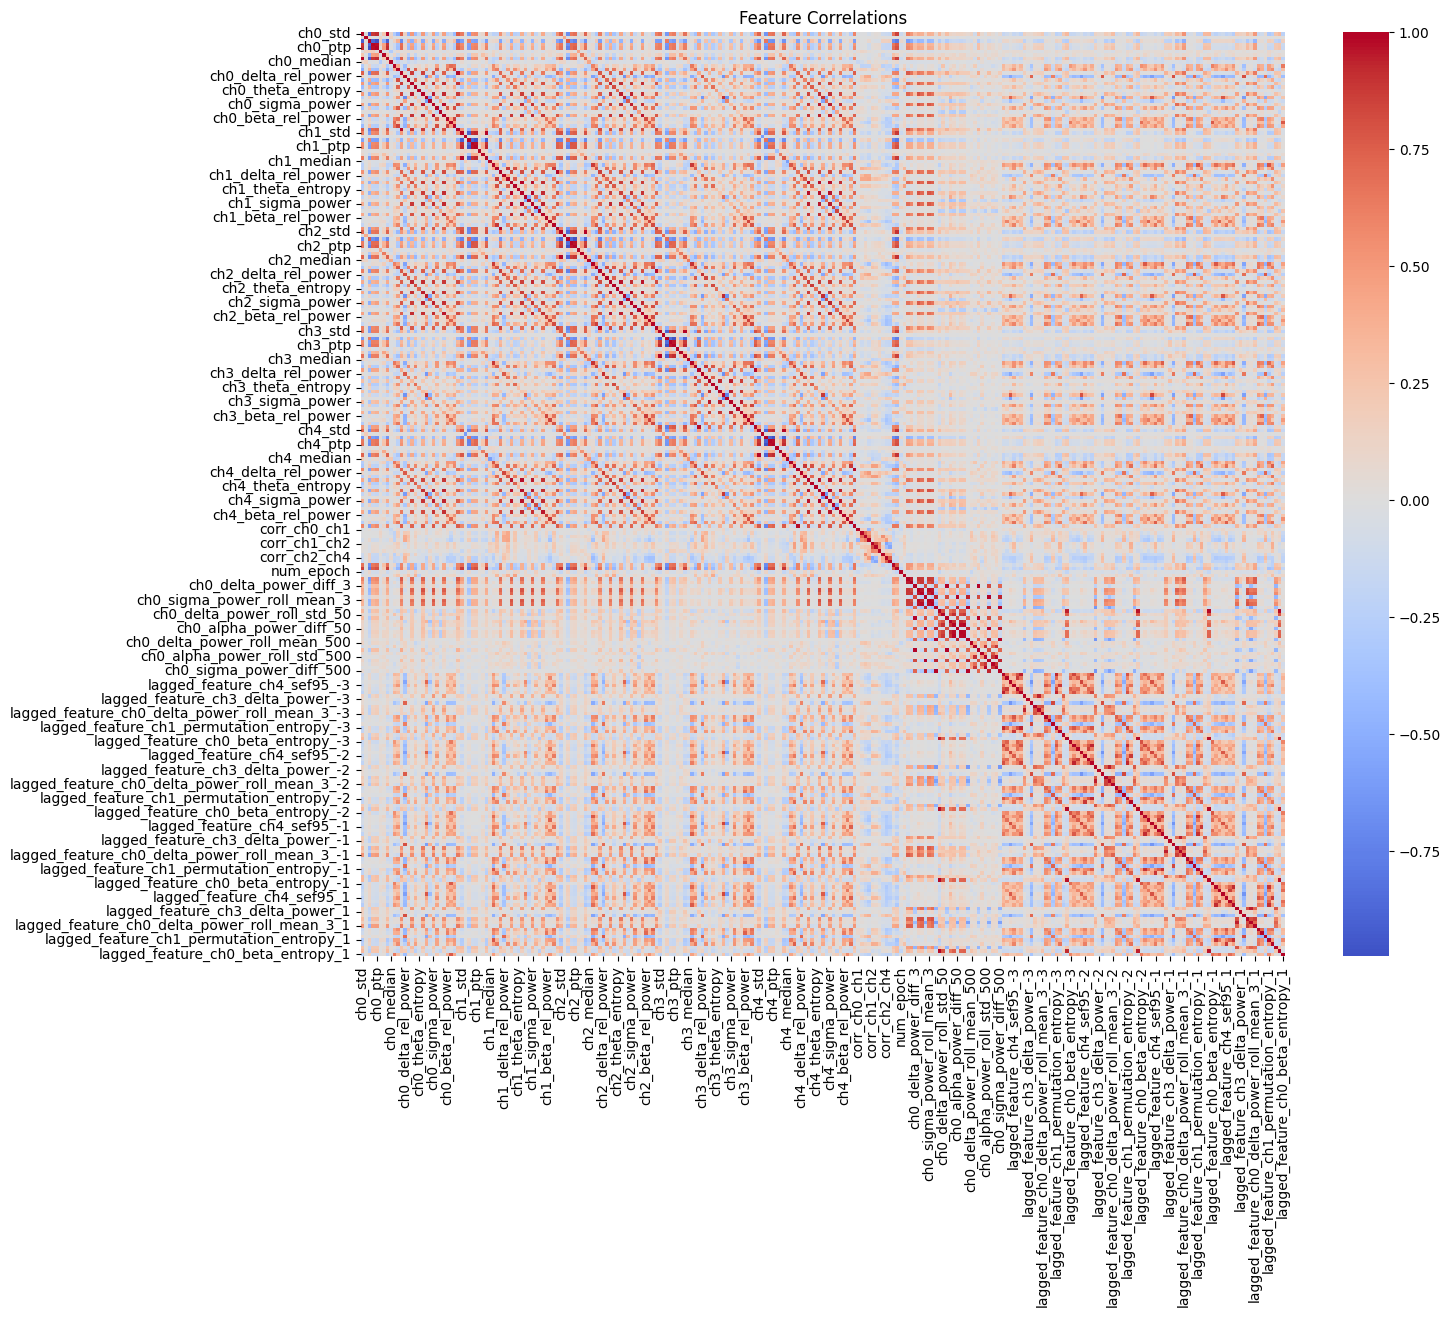

In [9]:
## Pas tres travaille pour l'instant, je voulais voir les correls et enlever ce qui est trop correle mais dure de faire de la feature selection

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations')
plt.show()

# Find highly correlated pairs (> 0.8 or <-0.8)
threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

## Build Model

### XGBoost models

In [10]:
# XGboost model train

X_df, y = df_features.drop(['num_signal'], axis=1), df['target'].astype(int)


# 1. Split 
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=12)


# 2. Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=12
)

model.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model.predict(X_test)

f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_per_class = f1_score(y_test, predictions, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")

F1 Score (macro): 0.8830
F1 Score (micro): 0.9186
Class 0 F1 Score: 0.9221
Class 1 F1 Score: 0.6632
Class 2 F1 Score: 0.9333
Class 3 F1 Score: 0.9591
Class 4 F1 Score: 0.9372


F1 Score (macro): 0.8661
F1 Score (micro): 0.9126
Class 0 F1 Score: 0.9118
Class 1 F1 Score: 0.5876
Class 2 F1 Score: 0.9330
Class 3 F1 Score: 0.9524
Class 4 F1 Score: 0.9458

In [11]:
## Create submission, so we use whole dataset for training

X_df, y = df_features.drop(['num_signal'], axis=1), df['target']
df_test = format_data(False)
X_test = create_features_parallel(df_test).drop(['num_signal'], axis=1)


# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test = scaler.transform(X_test)



# Model that performed best for now
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)



model.fit(X_train, y.astype(int))
predictions = model.predict(X_test)


#######
from scipy.signal import medfilt

def smooth_predictions(predictions, window_size=3):
    """Lisse les prédictions pour éviter les sauts rapides irréalistes."""
    # Le filtre médian remplace une valeur par la médiane de ses voisins
    return medfilt(predictions, kernel_size=window_size)



r = create_submission(df_test, smooth_predictions(predictions), "less_param")
r.head(40)

Processing 4077 epochs in parallel...
Adding temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
5,80005,2
6,80006,2
7,80007,2
8,80008,2
9,80009,2


## Try to use the fact that we have stage transitions that are more or less likely

In [12]:


import numpy as np

def calculate_priors_and_transitions(y_train):
    """
    Learns the 'rules' of sleep transitions from the training labels.
    Returns:
        priors: Probability of starting in each state.
        trans_mat: Matrix where [i, j] is prob of moving from state i to j.
    """
    classes = np.unique(y_train)
    n_classes = len(classes)
    
    # 1. Transition Matrix
    trans_mat = np.zeros((n_classes, n_classes))
    y = np.array(y_train).astype(int)
    
    # Count transitions (i -> j)
    for i in range(len(y) - 1):
        trans_mat[y[i], y[i+1]] += 1
        
    # Normalize rows (probabilities must sum to 1)
    # Add tiny epsilon to avoid division by zero
    trans_mat = trans_mat / (trans_mat.sum(axis=1, keepdims=True) + 1e-12)
    
    # 2. Priors (Initial state probabilities)
    # Simply frequency of each class in training (or just start of signals)
    priors = np.bincount(y, minlength=n_classes) / len(y)
    
    return np.log(priors + 1e-12), np.log(trans_mat + 1e-12)

def viterbi_decoding(probs, log_priors, log_trans_mat):
    """
    Finds the most likely sequence of states given XGBoost probabilities.
    probs: (n_epochs, n_classes) from model.predict_proba()
    """
    n_obs, n_classes = probs.shape
    
    # Log probabilities to prevent underflow
    log_probs = np.log(probs + 1e-12)
    
    # Initialize DP tables
    # path_score[t, s]: max probability of a path ending at time t in state s
    path_score = np.zeros((n_obs, n_classes))
    # backpointer[t, s]: the state at t-1 that led to best path at t, s
    backpointer = np.zeros((n_obs, n_classes), dtype=int)
    
    # Base case: first epoch
    path_score[0, :] = log_priors + log_probs[0, :]
    
    # Forward Pass
    for t in range(1, n_obs):
        for s in range(n_classes):
            # Calculate transition from all previous states to current state s
            # Score = Score(t-1) + Transition(prev->s) + Emission(s)
            scores = path_score[t-1, :] + log_trans_mat[:, s] + log_probs[t, s]
            
            # Store best score and best previous state
            path_score[t, s] = np.max(scores)
            backpointer[t, s] = np.argmax(scores)
            
    # Backward Pass (Backtracking)
    best_path = np.zeros(n_obs, dtype=int)
    
    # Start from the state with best final score
    best_path[-1] = np.argmax(path_score[-1, :])
    
    # Trace back
    for t in range(n_obs - 2, -1, -1):
        best_path[t] = backpointer[t+1, best_path[t+1]]
        
    return best_path

In [13]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

# ---------------------------------------------------------
# 1. PREPARE DATA & SPLIT BY SIGNAL (CRITICAL for Viterbi)
# ---------------------------------------------------------

# We need 'num_signal' to keep sequences intact, so we extract it before dropping
groups = df_features['num_signal']
X = df_features.drop(['num_signal'], axis=1)
y = df['target'].astype(int)

# GroupShuffleSplit ensures that if Signal_1 is in Test, ALL epochs of Signal_1 are in Test.
# This preserves the time sequence needed for HMM/Viterbi.
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=12)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# We need the signal IDs for the test set to run Viterbi loop later
test_groups = groups.iloc[test_idx] 

# ---------------------------------------------------------
# 2. SCALE
# ---------------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------------------------------------
# 3. TRAIN XGBOOST
# ---------------------------------------------------------
print("Training XGBoost...")
sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softprob', # Required for Viterbi
    eval_metric='mlogloss',
    random_state=12
)

model.fit(X_train, y_train, sample_weight=sample_weights)

# ---------------------------------------------------------
# 4. PREDICT & APPLY VITERBI
# ---------------------------------------------------------
print("Predicting probabilities & applying Viterbi...")

# A. Get raw probabilities from XGBoost
raw_probs = model.predict_proba(X_test)
raw_preds = np.argmax(raw_probs, axis=1) # Standard XGB predictions

# B. Learn HMM parameters from TRAINING labels only
log_priors, log_trans_mat = calculate_priors_and_transitions(y_train)

# C. Apply Viterbi per signal in the Test Set
viterbi_preds = np.zeros(len(y_test), dtype=int)
unique_test_signals = np.unique(test_groups)

# Map original dataframe indices to 0..N indices for our arrays
# We iterate through the unique signals present in our test split
for sig_id in unique_test_signals:
    # Find which rows in X_test belong to this signal
    # We use boolean masking on the test_groups array
    mask = (test_groups == sig_id)
    
    # Get the probabilities for just this signal
    signal_probs = raw_probs[mask]
    
    # Apply Viterbi
    smoothed_path = viterbi_decoding(signal_probs, log_priors, log_trans_mat)
    
    # Store results (fill in the slots for this signal)
    viterbi_preds[mask] = smoothed_path

# ---------------------------------------------------------
# 5. EVALUATE PERFORMANCE
# ---------------------------------------------------------

def print_metrics(y_true, y_pred, name):
    print(f"\n--- {name} Results ---")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")
    
    f1_per_class = f1_score(y_true, y_pred, average=None)
    for i, score in enumerate(f1_per_class):
        print(f"Class {i} F1 Score: {score:.4f}")

# Compare Raw XGBoost vs Viterbi Smoothed
print_metrics(y_test, raw_preds, "Standard XGBoost")
print_metrics(y_test, viterbi_preds, "XGBoost + Viterbi")

Training XGBoost...
Predicting probabilities & applying Viterbi...

--- Standard XGBoost Results ---
F1 Score (macro): 0.8454
F1 Score (micro): 0.8913
Class 0 F1 Score: 0.9097
Class 1 F1 Score: 0.5724
Class 2 F1 Score: 0.9290
Class 3 F1 Score: 0.9307
Class 4 F1 Score: 0.8855

--- XGBoost + Viterbi Results ---
F1 Score (macro): 0.8348
F1 Score (micro): 0.8939
Class 0 F1 Score: 0.9140
Class 1 F1 Score: 0.4781
Class 2 F1 Score: 0.9239
Class 3 F1 Score: 0.9431
Class 4 F1 Score: 0.9150


In [14]:
## Create submission, so we use whole dataset for training

# 1. Prepare Training Data
X_df, y = df_features.drop(['num_signal'], axis=1), df['target']

# 2. Prepare Test Data (KEEP num_signal for grouping)
# We generate features, but split them into IDs and X_test
test_features_full = create_features_parallel(df_test)
test_signal_ids = test_features_full['num_signal'].values # Save IDs for later
X_test = test_features_full.drop(['num_signal'], axis=1)

# 3. Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test_scaled = scaler.transform(X_test)

# 4. Train Model
# Note: 'multi:softprob' is required to get probabilities
model = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    reg_lambda=1.0,
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=42 # Replaced random_state variable for clarity
)

print("Training XGBoost...")
model.fit(X_train, y.astype(int))

# 5. Get PROBABILITIES (Not just class predictions)
print("Predicting probabilities...")
raw_probs = model.predict_proba(X_test_scaled)

# ---------------------------------------------------------
# HMM / VITERBI SMOOTHING
# ---------------------------------------------------------
print("Applying Viterbi Smoothing...")

# A. Learn transition matrix from training labels
log_priors, log_trans_mat = calculate_priors_and_transitions(y)

# B. Apply Viterbi per signal
# We must iterate signal by signal so the algorithm knows where a night starts/ends
final_predictions = np.zeros(len(raw_probs), dtype=int)
unique_signals = np.unique(test_signal_ids)

for sig_id in unique_signals:
    # Find indices for this specific recording
    idx = np.where(test_signal_ids == sig_id)[0]
    
    # Get probabilities for this recording
    signal_probs = raw_probs[idx]
    
    # Apply Viterbi to this recording
    smoothed_path = viterbi_decoding(signal_probs, log_priors, log_trans_mat)
    
    # Store results
    final_predictions[idx] = smoothed_path

# ---------------------------------------------------------

r = create_submission(df_test, final_predictions, "XGB_with_Viterbi")
r.head(40)

Processing 4077 epochs in parallel...
Adding temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_17776\249050607.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


Training XGBoost...
Predicting probabilities...
Applying Viterbi Smoothing...


In [15]:
r = create_submission(df_test, final_predictions, "XGB_with_Viterbi")
r.head(40)

labels that are not in boths sets :  set()


,identifier,target
0,80000,2
1,80001,2
2,80002,2
3,80003,2
4,80004,2
5,80005,2
6,80006,2
7,80007,2
8,80008,2
9,80009,2


In [58]:
#######
from scipy.signal import medfilt

def smooth_predictions(predictions, window_size=3):
    """Lisse les prédictions pour éviter les sauts rapides irréalistes."""
    # Le filtre médian remplace une valeur par la médiane de ses voisins
    return medfilt(predictions, kernel_size=window_size)



r = create_submission(df_test, predictions, "less_param")
r.head(40)

labels that are not in boths sets :  set()


,identifier,target
0,80000,4
1,80001,4
2,80002,4
3,80003,4
4,80004,4
5,80005,4
6,80006,4
7,80007,4
8,80008,4
9,80009,4


In [61]:
feature_importance = pd.DataFrame({
    'feature': X_df.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance.head(20)

,feature,importance
102,ch3_alpha_rel_power,0.060961
53,ch1_beta_entropy,0.058610
65,ch2_permutation_entropy,0.055788
201,lagged_feature_ch1_beta_entropy_-2,0.041871
138,ch4_sef95,0.040404
221,lagged_feature_ch1_beta_entropy_-1,0.029660
220,lagged_feature_ch2_permutation_entropy_-1,0.027182
240,lagged_feature_ch2_permutation_entropy_1,0.026906
109,ch3_beta_entropy,0.026347
93,ch3_permutation_entropy,0.021486


In [57]:
r.value_counts('target')

target
2    2105
3     785
4     709
0     403
1      75
Name: count, dtype: int64

In [42]:
# Or as a sorted dictionary with feature names

feature_importance = pd.DataFrame({
    'feature': X_df.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)




top_20_features = feature_importance['feature'].head(20).tolist()


df_features = df_features.sort_values(['num_signal', 'num_epoch'])

# 3. Define the lags you want
# -1 = Previous epoch (t-1)
#  1 = Next epoch (t+1)
lags = [-3, -2, -1, 1] 

# 4. Vectorized implementation (No loops over rows!)
for lag in lags:
    shifted_data = df_features.groupby('num_signal')[top_20_features].shift(lag)
    
    # Rename the columns
    shifted_data.columns = [f"lagged_feature_{col}_{lag}" for col in top_20_features]
    
    # Concatenate to the original dataframe
    df_features = pd.concat([df_features, shifted_data], axis=1)

# 5. Fill NaN values
# The shift creates NaNs at the very start/end of each recording.
# Filling with 0 is usually safe for tree-based models (XGBoost/RandomForest)
df_features = df_features.fillna(0)


In [ ]:
# Create a submission for simple random forest
## This showed us that all the models perform similarly, so we need one more good feature probably to be well ranked in the leaderbord

rf = RandomForestClassifier(
    max_depth=15, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)


rf.fit(X_train, y.astype(int))
predictions = rf.predict(X_test)

create_submission(df_test, predictions, 'rf_')

labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
## Same for SVM that performs similarly to the other models
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM with custom class weights
svm = SVC(
    kernel='rbf',  # or 'linear', 'poly'
    C=1.0,
    gamma='scale',
    class_weight={0: 1, 1: 6, 2: 1, 3: 1, 4: 1},  # Boost class 1
    random_state=42,
    probability=False  # Enable if you need predict_proba
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"\nTest Set Results:")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print("\nPer-class F1 Scores:")
for class_idx, score in enumerate(f1_per_class):
    print(f"  Class {class_idx}: {score:.4f}")


Test Set Results:
F1 Macro: 0.8279
F1 Weighted: 0.8745

Per-class F1 Scores:
  Class 0: 0.8720
  Class 1: 0.5442
  Class 2: 0.9062
  Class 3: 0.9346
  Class 4: 0.8824
